## Imports

In [1]:
import os
import cv2
import json
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

## Step 1: Load the video

In [2]:
def load_video(video_name, folder_path="../../data/train_sample_videos"):
    video_path = os.path.join(folder_path, video_name)
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video {video_name} not found in {folder_path}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open the video: {video_name}")

    print(f"Successfully loaded video: {video_name}")
    return cap

In [3]:
def load_video_full_path(file_path):
    """
    Loads the video using OpenCV.

    Args:
        file_path (str): Full path to the video file.

    Returns:
        cap: OpenCV video capture object.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Video not found: {file_path}")

    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open the video: {file_path}")

    print(f"Successfully loaded video: {os.path.basename(file_path)}")
    return cap

In [4]:
# Testing the function
video_name = "aagfhgtpmv.mp4"  # Replace with an actual video filename in your folder
cap = load_video(video_name)

Successfully loaded video: aagfhgtpmv.mp4


## Step 2: Convert video into pictures

In [5]:
def extract_frames(cap, frame_interval=1):
    frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Exit if no more frames are available

        if frame_count % frame_interval == 0:  # Check if the current frame should be extracted
            # Resize frame to (224, 224) for CNN input
            resized_frame = cv2.resize(frame, (224, 224)) / 255.0  # Normalize to [0, 1]
            frames.append(resized_frame)

        frame_count += 1

    return frames

In [6]:
# Test usage
video_name = "aagfhgtpmv.mp4"  # Replace with an actual video filename in your folder
cap = load_video(video_name)
frames = extract_frames(cap, frame_interval=5)  # Extract every 5th frame
print(f"Extracted {len(frames)} frames.")

Successfully loaded video: aagfhgtpmv.mp4
Extracted 60 frames.


In [7]:
def save_frames(frames, output_folder="./extracted_frames"):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    for frame_count, frame in enumerate(frames):
        # Save the frame as an image file
        output_path = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(output_path, (frame * 255).astype('uint8'))  # Convert back to [0, 255] for saving

    print(f"Saved {len(frames)} frames to {output_folder}")

In [8]:
# save_frames(frames)

## Step 3: Create dataset (train, test, val)

In [9]:
def create_datasets(base_dir="../../data"):
    train_data = []
    val_data = []
    test_data = []

    # Define the folders and subfolders to iterate through
    for folder in ['train', 'validation', 'test']:
        for subfolder in ['real', 'deepfake']:
            subfolder_path = os.path.join(base_dir, folder, subfolder)

            # Check if the subfolder exists
            if not os.path.exists(subfolder_path):
                print(f"Subfolder {subfolder_path} does not exist.")
                continue

            # Loop through each file in the subfolder
            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.mp4', '.avi', '.mov')):  # Add any other video formats if needed
                    # Create a label based on the subfolder
                    label = 1 if subfolder == 'deepfake' else 0
                    # Append the file path and label to the appropriate dataset list
                    if folder == 'train':
                        train_data.append({
                            'file_path': os.path.join(subfolder_path, filename),
                            'label': label
                        })
                    elif folder == 'validation':
                        val_data.append({
                            'file_path': os.path.join(subfolder_path, filename),
                            'label': label
                        })
                    elif folder == 'test':
                        test_data.append({
                            'file_path': os.path.join(subfolder_path, filename),
                            'label': label
                        })

    # Create DataFrames from the collected data
    train_df = pd.DataFrame(train_data)
    val_df = pd.DataFrame(val_data)
    test_df = pd.DataFrame(test_data)

    return train_df, val_df, test_df

In [10]:
train_df, val_df, test_df = create_datasets()

In [11]:
train_df

,file_path,label
0,../../data\train\real\abarnvbtwb.mp4,0
1,../../data\train\real\aelfnikyqj.mp4,0
2,../../data\train\real\afoovlsmtx.mp4,0
3,../../data\train\real\asaxgevnnp.mp4,0
4,../../data\train\real\atvmxvwyns.mp4,0
...,...,...
257,../../data\train\deepfake\esckbnkkvb.mp4,1
258,../../data\train\deepfake\esgftaficx.mp4,1
259,../../data\train\deepfake\esxrvsgpvb.mp4,1
260,../../data\train\deepfake\esyrimvzsa.mp4,1


## Step 4: Preprocessing

In [12]:
def preprocess_frame(frame, target_size=(224, 224)):
    """
    Preprocesses a video frame for the CNN model.
    
    Args:
        frame (np.ndarray): Original frame.
        target_size (tuple): Desired frame size (height, width).

    Returns:
        np.ndarray: Preprocessed frame ready for the model.
    """
    # Resize frame to the target size
    frame = cv2.resize(frame, target_size)

    # Normalize pixel values to range [0, 1]
    frame = frame / 255.0

    return frame

In [13]:
preprocessed_frames = [preprocess_frame(frame) for frame in frames]
print(f"Shape of first preprocessed frame: {preprocessed_frames[0].shape}")

Shape of first preprocessed frame: (224, 224, 3)


## Step 5: Build CNN Model

In [14]:
def create_cnn_model(input_shape=(224, 224, 3)):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten and Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(1, activation='sigmoid'))  # Binary output (real or fake)

    return model

## Step 6: Training

In [15]:
def prepare_data(df, frame_rate=5, target_size=(224, 224)):
    X, y = [], []
    for _, row in df.iterrows():
        cap = load_video_full_path(row['file_path'])
        frames = extract_frames(cap, frame_rate)
        preprocessed_frames = [preprocess_frame(frame, target_size) for frame in frames]
        X.extend(preprocessed_frames)
        y.extend([row['label']] * len(preprocessed_frames))  # Same label for all frames
    return np.array(X), np.array(y)

In [16]:
X_train, y_train = prepare_data(train_df)
X_val, y_val = prepare_data(val_df)
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")

Successfully loaded video: abarnvbtwb.mp4
Successfully loaded video: aelfnikyqj.mp4
Successfully loaded video: afoovlsmtx.mp4
Successfully loaded video: asaxgevnnp.mp4
Successfully loaded video: atvmxvwyns.mp4
Successfully loaded video: avmjormvsx.mp4
Successfully loaded video: axntxmycwd.mp4
Successfully loaded video: aybumesmpk.mp4
Successfully loaded video: bddjdhzfze.mp4
Successfully loaded video: bdnaqemxmr.mp4
Successfully loaded video: beboztfcme.mp4
Successfully loaded video: beyebyhrph.mp4
Successfully loaded video: bffwsjxghk.mp4
Successfully loaded video: bgvhtpzknn.mp4
Successfully loaded video: bgwmmujlmc.mp4
Successfully loaded video: bilnggbxgu.mp4
Successfully loaded video: bmjzrlszhi.mp4
Successfully loaded video: bpapbctoao.mp4
Successfully loaded video: brwrlczjvi.mp4
Successfully loaded video: bulkxhhknf.mp4
Successfully loaded video: bwhlgysghg.mp4
Successfully loaded video: bwipwzzxxu.mp4
Successfully loaded video: bxzakyopjf.mp4
Successfully loaded video: bzythlf

In [17]:
cnn_model = create_cnn_model()
cnn_model.summary()
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

C:\Users\jhau2\.virtualenvs\dsa4266-project-thxkCpQA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 277s 557ms/step - accuracy: 0.7956 - loss: 0.5220 - val_accuracy: 0.8138 - val_loss: 0.4866
Epoch 2/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 242s 491ms/step - accuracy: 0.8067 - loss: 0.5035 - val_accuracy: 0.8138 - val_loss: 0.4834
Epoch 3/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 247s 501ms/step - accuracy: 0.8091 - loss: 0.4990 - val_accuracy: 0.8138 - val_loss: 0.4810
Epoch 4/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 260s 528ms/step - accuracy: 0.8070 - loss: 0.4989 - val_accuracy: 0.8138 - val_loss: 0.4854
Epoch 5/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 253s 514ms/step - accuracy: 0.8050 - loss: 0.5028 - val_accuracy: 0.8138 - val_loss: 0.4827
Epoch 6/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 260s 529ms/step - accuracy: 0.8003 - loss: 0.5048 - val_accuracy: 0.8138 - val_loss: 0.4874
Epoch 7/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 256s 518ms/step - accuracy: 0.8066 - loss: 0.4950 - val_accuracy: 0.8138 - val_loss: 0.4860
Epoch 8/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 241s 490ms/step - accuracy: 0.8106 -

## Step 7: Predictions

In [19]:
def predict_video(video_path, model, threshold=0.5):
    """Predict if a video is real or deepfake based on majority voting."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open the video: {video_path}")

    frame_count = 0
    deepfake_frames = 0

    # Iterate over all frames in the video
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        # Resize frame to match input size of the model
        frame_resized = cv2.resize(frame, (224, 224)) / 255.0  # Normalize frame
        frame_resized = np.expand_dims(frame_resized, axis=0)  # Add batch dimension

        # Predict frame label (probability)
        pred_prob = model.predict(frame_resized)[0][0]  # Get the probability for 'deepfake'
        frame_label = 1 if pred_prob >= threshold else 0  # Classify as 1 (deepfake) or 0 (real)

        # Update counters
        deepfake_frames += frame_label
        frame_count += 1

    cap.release()  # Release video capture

    # Majority voting: If > 50% frames are deepfake, classify video as deepfake
    video_label = 1 if deepfake_frames / frame_count > 0.5 else 0
    return video_label

In [20]:
def predict_on_test_set_videos(test_df, model, threshold=0.5):
    """Predict labels for all videos in the test set and compare with ground truth."""
    y_true, y_pred = [], []

    # Iterate over each video in the test set
    for _, row in test_df.iterrows():
        video_path = row['file_path']
        true_label = row['label']

        # Predict the video label using your function
        predicted_label = predict_video(video_path, model, threshold)

        # Store predictions and ground truth
        y_true.append(true_label)
        y_pred.append(predicted_label)

    return np.array(y_true), np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

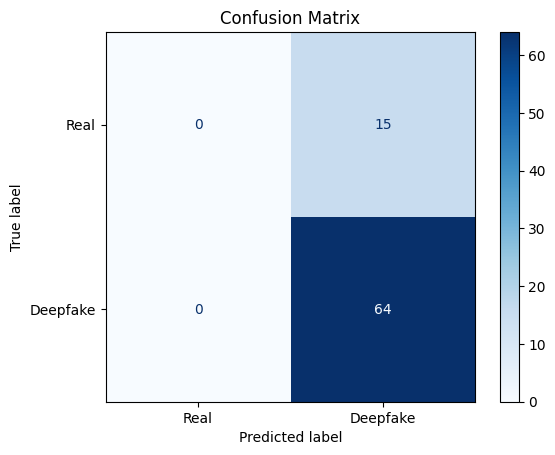

              precision    recall  f1-score   support

        Real       0.00      0.00      0.00        15
    Deepfake       0.81      1.00      0.90        64

    accuracy                           0.81        79
   macro avg       0.41      0.50      0.45        79
weighted avg       0.66      0.81      0.73        79



C:\Users\jhau2\.virtualenvs\dsa4266-project-thxkCpQA\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jhau2\.virtualenvs\dsa4266-project-thxkCpQA\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jhau2\.virtualenvs\dsa4266-project-thxkCpQA\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [21]:
# Predict on the test set
y_true, y_pred = predict_on_test_set_videos(test_df, cnn_model)

# Compute confusion matrix and display it
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Deepfake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Real", "Deepfake"]))